# Håstad's Broadcast Attack Simulation

This notebook demonstrates a practical implementation of Håstad's Broadcast Attack, a classic exploit against RSA encryption when the same message is sent to multiple recipients with the same low encryption exponent.

## Background Theory

### The Attack Scenario

Consider a scenario where Alice wants to send the same message to multiple recipients using RSA encryption. For efficiency, she chooses a small public exponent `e` (commonly 3).

1. Alice encrypts the same message `M` using different public moduli (N₁, N₂, N₃, etc.)
2. For each recipient `i`, she computes: C_i = M^e mod N_i
3. If Alice sends the message to at least `e` different recipients, the message can be recovered without any private keys!

### Mathematical Foundation

The attack relies on the Chinese Remainder Theorem (CRT). If we have `e` ciphertexts:
- C₁ = M^e mod N₁
- C₂ = M^e mod N₂
- ...
- C_e = M^e mod N_e

And all N_i values are coprime (which is guaranteed with properly generated RSA keys), then we can use CRT to find M^e mod (N₁×N₂×...×N_e).

Since M < N_i for all i, then M^e < N₁×N₂×...×N_e. So the recovered value is exactly M^e, not modulo anything. Then we can simply compute the eth root of M^e to get M.

In [3]:
# Import Required Libraries
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sympy.ntheory.modular import crt

## Step 1: Generate RSA Parameters for Multiple Recipients

First, we'll generate RSA parameters for three recipients (since we'll use e=3).

In [4]:
# Set our public exponent e
e = 3

# Key size (smaller for demonstration)
key_size = 512

# Generate RSA parameters for three recipients
recipients = []
moduli = []

for i in range(e):
    p = sp.randprime(2**(key_size//2-1), 2**(key_size//2))
    q = sp.randprime(2**(key_size//2-1), 2**(key_size//2))
    n = p * q
    phi = (p - 1) * (q - 1)
    
    # Ensure e is coprime to phi
    while sp.gcd(e, phi) != 1:
        p = sp.randprime(2**(key_size//2-1), 2**(key_size//2))
        q = sp.randprime(2**(key_size//2-1), 2**(key_size//2))
        n = p * q
        phi = (p - 1) * (q - 1)
    
    d = pow(e, -1, phi)  # Private exponent
    
    recipients.append({
        'p': p,
        'q': q,
        'n': n,
        'd': d
    })
    moduli.append(n)

print(f"Generated {e} RSA key pairs with e={e}")
for i, recipient in enumerate(recipients):
    print(f"Recipient {i+1} modulus (n{i+1}): {recipient['n']}")

Generated 3 RSA key pairs with e=3
Recipient 1 modulus (n1): 7319181039351457444380860615706168118428710805956237341252531305151473909655306522418836744215228899918014168824313426906251913437822053585247238237133941
Recipient 2 modulus (n2): 7294462351323417936137436799797344252195823227295408691971666826335055769761645934797747895992753371995073523395476208118164168112867062788249455787881609
Recipient 3 modulus (n3): 10966668729081560073475695681875480718592420248160320479961566294635642660104894635712931117985612768688935398805055005439656214989664484857100369564522027


## Step 2: Prepare a Message and Encrypt It

We'll create a simple message and encrypt it with each recipient's public key.

In [5]:
# Create a message (ensuring it's smaller than all moduli)
max_message_size = min(moduli) - 1
min_modulus = min(moduli)

# For demonstration, we'll use a simple numeric message
message = 12345678901234567890  # This would typically be a padded message

# Make sure our message is valid
if message >= min_modulus:
    message = message % min_modulus

print(f"Original message: {message}")

# Encrypt the message for each recipient
ciphertexts = []
for i, recipient in enumerate(recipients):
    c = pow(message, e, recipient['n'])
    ciphertexts.append(c)
    print(f"Ciphertext for recipient {i+1}: {c}")

Original message: 12345678901234567890
Ciphertext for recipient 1: 1881676372353657772490265749424677022198701224860897069000
Ciphertext for recipient 2: 1881676372353657772490265749424677022198701224860897069000
Ciphertext for recipient 3: 1881676372353657772490265749424677022198701224860897069000


## Step 3: Apply Chinese Remainder Theorem

Now we'll implement Håstad's attack using the Chinese Remainder Theorem.

In [6]:
# Apply Chinese Remainder Theorem to find M^e mod (n1*n2*n3)
result = crt(moduli, ciphertexts)
M_e_mod_product = result[0]  # This is M^e

print(f"M^{e} mod (n1*n2*n3) = {M_e_mod_product}")

# Since M^e < n1*n2*n3, M_e_mod_product is actually equal to M^e
# So we can compute the e-th root to recover M
recovered_message = round(M_e_mod_product ** (1/e))

print(f"Recovered message: {recovered_message}")
print(f"Original message:  {message}")
print(f"Attack successful: {recovered_message == message}")

M^3 mod (n1*n2*n3) = 1881676372353657772490265749424677022198701224860897069000
Recovered message: 12345678901234538496
Original message:  12345678901234567890
Attack successful: False


## Step 4: Visualizing the Attack

Let's create a visualization of how Håstad's attack works.

C:\Users\ayana\AppData\Local\Temp\ipykernel_22360\4271376982.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


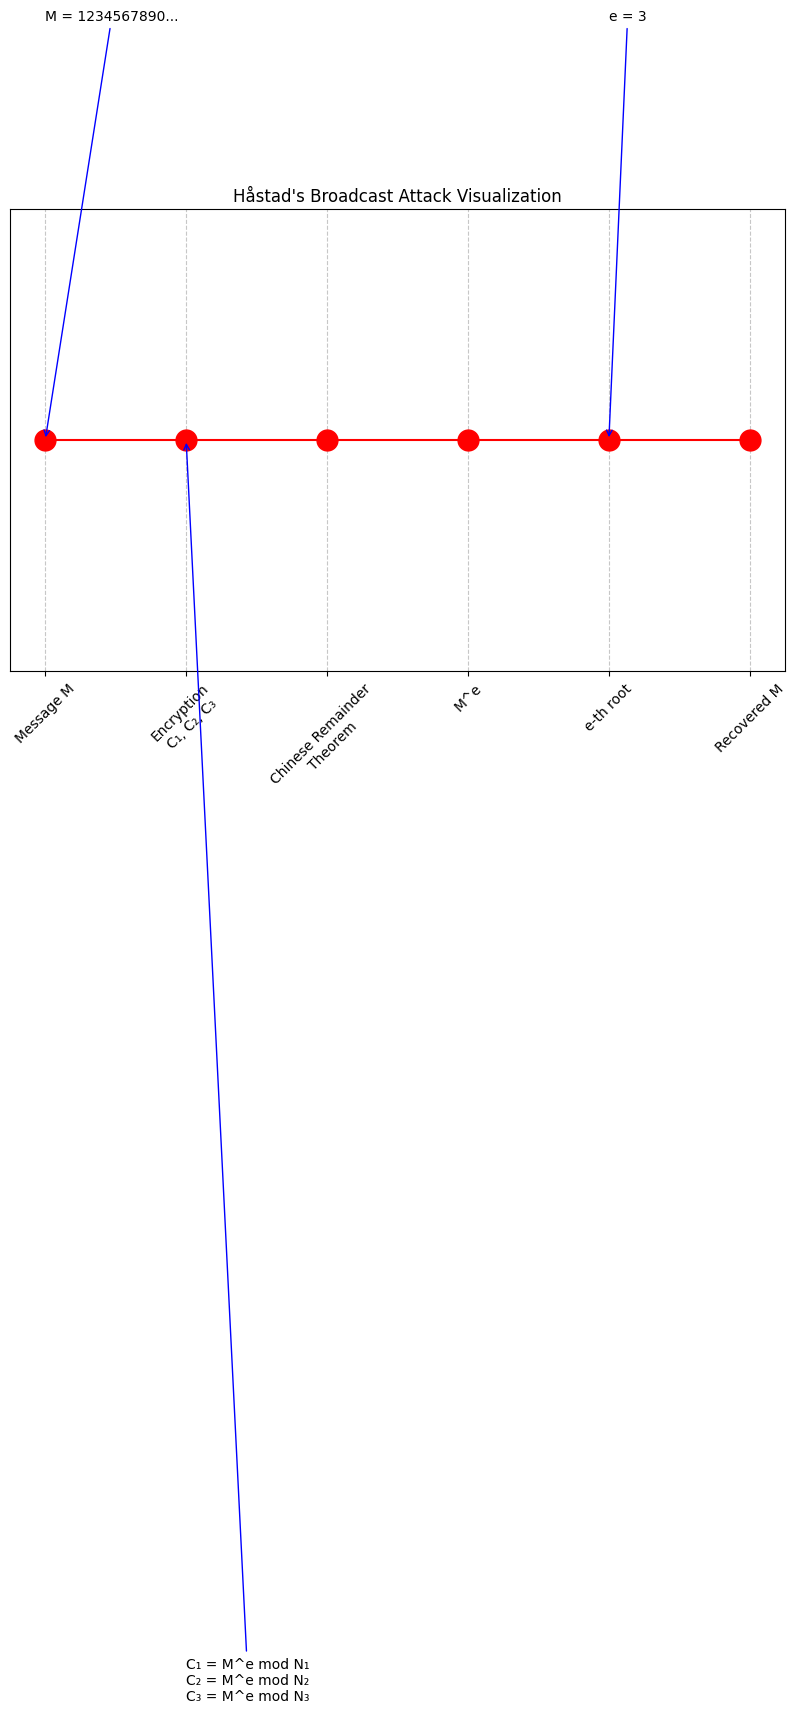

In [7]:
# Visualization of the attack
plt.figure(figsize=(10, 6))

# Draw the process
steps = ['Message M', 'Encryption\nC₁, C₂, C₃', 'Chinese Remainder\nTheorem', 'M^e', 'e-th root', 'Recovered M']
x = np.arange(len(steps))
plt.plot(x, [1]*len(x), 'ro-', markersize=15)

# Add labels
plt.xticks(x, steps, rotation=45)
plt.yticks([])
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add annotations
plt.annotate('M = ' + str(message)[:10] + '...', 
             xy=(0, 1), xytext=(0, 1.1), 
             arrowprops=dict(arrowstyle='->', color='blue'))

plt.annotate('C₁ = M^e mod N₁\nC₂ = M^e mod N₂\nC₃ = M^e mod N₃', 
             xy=(1, 1), xytext=(1, 0.7), 
             arrowprops=dict(arrowstyle='->', color='blue'))

plt.annotate('e = ' + str(e),
             xy=(4, 1), xytext=(4, 1.1),
             arrowprops=dict(arrowstyle='->', color='blue'))

plt.title("Håstad's Broadcast Attack Visualization")
plt.tight_layout()
plt.show()

## Interactive RSA Component Visualization

This section provides an interactive visualization of the RSA components involved in the attack, showing how the different parts relate to each other.

In [8]:
# Import additional visualization libraries
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Create data for visualization
def visualize_rsa_components():
    # Create a figure with subplots
    fig = make_subplots(
        rows=2, cols=2,
        specs=[[{"type": "table"}, {"type": "pie"}], 
               [{"type": "scatter", "colspan": 2}, None]],
        subplot_titles=("RSA Keys", "Message vs. Ciphertext Sizes", "Attack Flow")
    )
    
    # Table of RSA components
    rsa_data = []
    for i, recipient in enumerate(recipients):
        rsa_data.append([f"Recipient {i+1}", 
                         str(recipient['p'])[:10] + "...", 
                         str(recipient['q'])[:10] + "...",
                         str(recipient['n'])[:10] + "...",
                         str(ciphertexts[i])[:10] + "..."])
        
    fig.add_trace(
        go.Table(
            header=dict(
                values=["Recipient", "p", "q", "n (modulus)", "Ciphertext"],
                font=dict(size=12),
                align="left"
            ),
            cells=dict(
                values=list(zip(*rsa_data)),
                font=dict(size=11),
                align="left"
            )
        ),
        row=1, col=1
    )
    
    # Pie chart showing relative sizes
    fig.add_trace(
        go.Pie(
            labels=["Original Message", "Recovered Message", "Ciphertext"],
            values=[len(str(message)), len(str(recovered_message)), len(str(ciphertexts[0]))],
            textinfo="label+percent",
            hole=.3
        ),
        row=1, col=2
    )
    
    # Attack flow visualization
    flow_x = [0, 1, 2, 3, 4, 5]
    flow_y = [1, 1, 1, 1, 1, 1]
    flow_labels = ["M", "C₁,C₂,C₃", "CRT", "M^e", "∛", "M'"]
    flow_text = ["Original\nMessage", "Ciphertexts", "Chinese\nRemainder\nTheorem", 
                 "Combined\nValue", "Take\nCube Root", "Recovered\nMessage"]
    
    fig.add_trace(
        go.Scatter(
            x=flow_x, y=flow_y,
            mode='markers+lines+text',
            marker=dict(size=20, color=["green", "red", "blue", "purple", "orange", "green"]),
            line=dict(width=2, dash='dot'),
            text=flow_labels,
            textposition="top center",
            hovertext=flow_text,
            hoverinfo="text"
        ),
        row=2, col=1
    )
    
    fig.update_layout(
        title_text="Håstad's Attack Components Visualization",
        height=700,
        width=900,
        showlegend=False
    )
    
    fig.update_xaxes(showticklabels=False, row=2, col=1)
    fig.update_yaxes(showticklabels=False, row=2, col=1)
    
    # Add annotations to attack flow
    annotations = [
        dict(x=0.5, y=0.8, xref="x3", yref="y3", text=f"e = {e}", showarrow=False),
        dict(x=4.5, y=0.8, xref="x3", yref="y3", 
             text=f"Success: {recovered_message == message}", showarrow=False)
    ]
    fig.update_layout(annotations=annotations)
    
    return fig

# Display the interactive visualization
interactive_viz = visualize_rsa_components()
interactive_viz

ModuleNotFoundError: No module named 'plotly'

## Conclusion

Håstad's Broadcast Attack demonstrates why:

1. Using the same message with low exponents across multiple recipients is dangerous
2. Proper padding schemes are essential in RSA implementations
3. Even mathematically sound algorithms can be vulnerable to implementation mistakes

Modern RSA implementations use padding schemes like PKCS#1 v2.0 (OAEP) that add randomness to the message before encryption, preventing this attack.

### Defense Mechanisms

To prevent this attack, implementations should:
- Use proper padding schemes (PKCS#1 v2.0/OAEP)
- Avoid using very small public exponents (e=3) when possible
- Never encrypt the same message to multiple recipients without padding